In [1]:
import pandas as pd
import numpy as np
from PythonFunctions import wrangle, scale, explore, cluster, evaluate
import warnings
warnings.filterwarnings("ignore")

## Wrangle 

In [2]:
zillow = wrangle.get_all_zillow_data()
zillow = zillow.sort_values('transactiondate').drop_duplicates('parcelid',keep='last')

In [3]:
zillow.shape

(77381, 69)

In [4]:
col, row = wrangle.get_nulls(zillow)

<class 'pandas.core.series.Series'>


In [5]:
#drop any col missing 30% of its data
zillow = wrangle.drop_null_columns(zillow,30)

<class 'pandas.core.series.Series'>


In [6]:
#drop any row missing 70% of its data
zillow = wrangle.drop_null_rows(zillow, 70)

In [7]:
#drop remaining data
zillow = zillow.dropna()

In [8]:
zillow.isna().sum().sum()

0

In [9]:
zillow.shape

(64065, 30)

In [10]:
#for i in zillow.columns:
    #print(zillow[i].value_counts())

### Feature Engineering 
- extracted month from transactiondate
- created tax rate based on taxdollarvaluecnt and tax amount
- changed log error to the absolule log error 

In [11]:
zillow = wrangle.zillow_engineering(zillow)

In [12]:
#filter by single unit housing
zillow = zillow[(zillow.propertylandusedesc == 'Single Family Residential') |
          (zillow.propertylandusedesc == 'Mobile Home') |
          (zillow.propertylandusedesc == 'Manufactured, Modular, Prefabricated Homes') |
          (zillow.propertylandusedesc == 'Townhouse')]
zillow.shape

(50628, 33)

## Split/Scale

In [13]:
train , validate, test = wrangle.split_for_model(zillow)
train_scaled, validate_scaled, test_scaled = scale.scale_data(train, validate, test, 'MinMax',\
                                                              to_scale=['log10price','calculatedfinishedsquarefeet','latitude','longitude',\
                                                                        'lotsizesquarefeet', 'yearbuilt','structuretaxvaluedollarcnt',\
                                                                        'taxvaluedollarcnt', 'taxamount', 'landtaxvaluedollarcnt','taxrate','finishedsquarefeet12'])

train(28351, 33),validate(12151, 33),test(10126, 33)


## Explore

### Exploring Variables in relation to Target = Log Error

In [14]:
cont_vars = ['logerror','log10price','calculatedfinishedsquarefeet','latitude','longitude','lotsizesquarefeet', 'yearbuilt','structuretaxvaluedollarcnt',\
             'taxvaluedollarcnt', 'taxamount', 'landtaxvaluedollarcnt','taxrate','finishedsquarefeet12', 'transactionmonth','bathroomcnt','bedroomcnt' , 'regionidzip']
target = 'logerror'

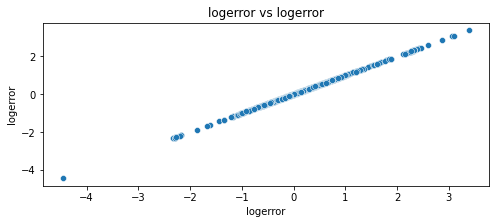

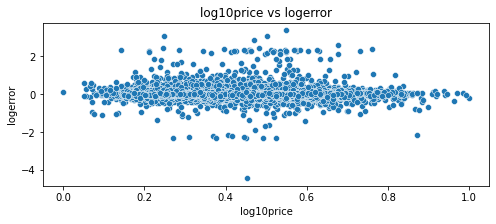

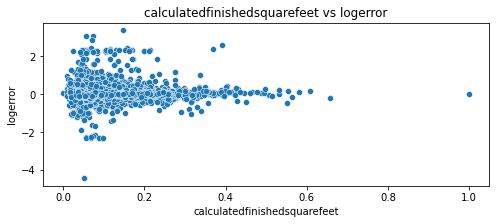

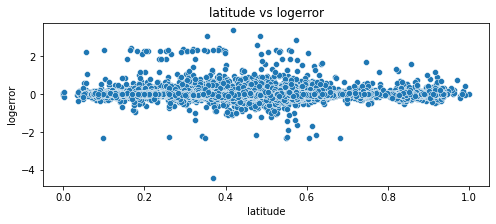

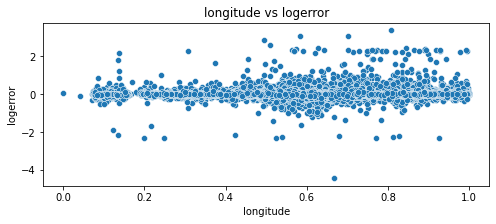

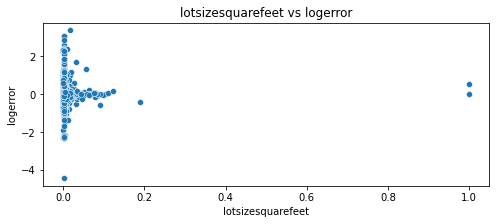

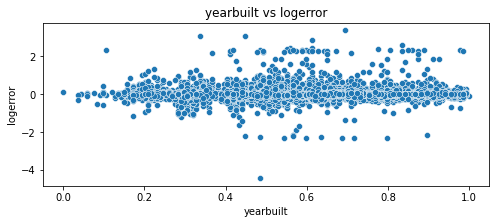

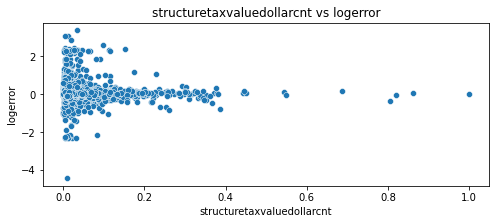

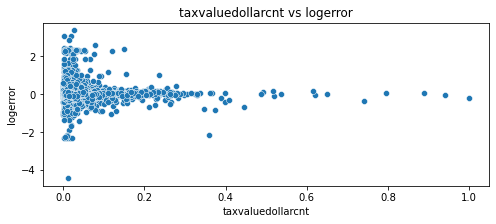

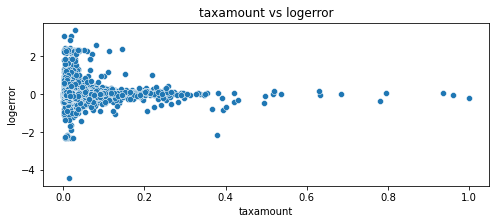

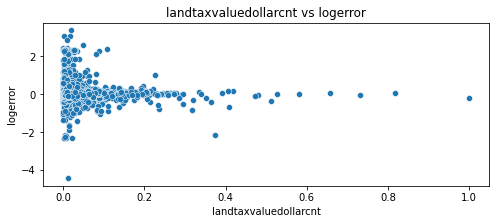

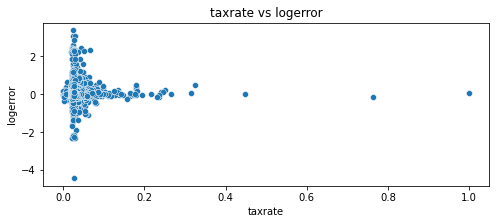

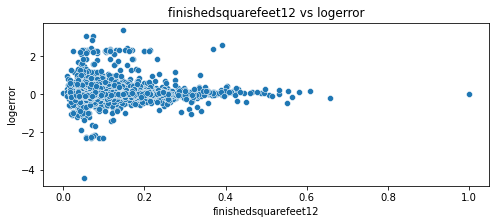

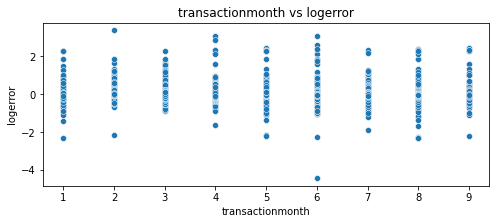

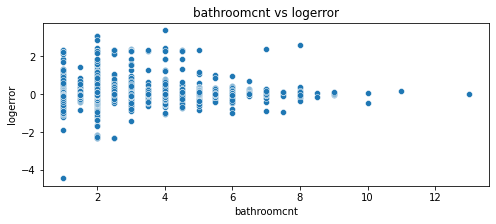

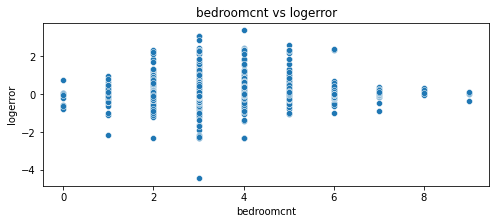

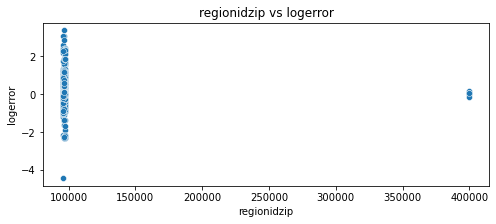

In [15]:
explore.compare_to_target(train_scaled[cont_vars], target)

## Take Aways
- Pricing, Size, and Age of the house play a big role in Log Error 
- The more houses are similar to eachother in terms of these 3 main topics , the harder it is to predict there price accurately
    * Why? maybe our data needs to know more about its position?
- we will look more into age vs price vs size , cluster these and see if these types of houses prioritize diffrent drivers for predicting logerror and model to their needs for a possibly better predicitons

## Clustering 
### Target = Logerror 

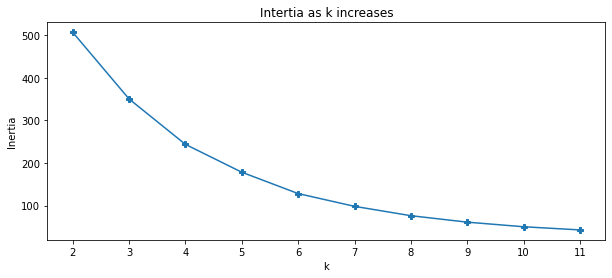

In [16]:
X = train_scaled[['logerror']]
cluster.view_intertia(X)

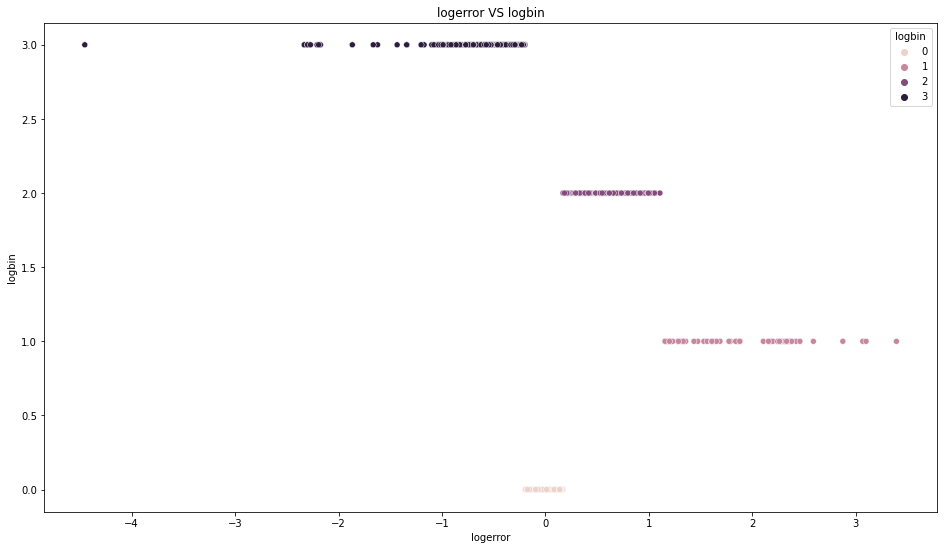

In [17]:
X = cluster.show_cluster(X, 4, 'logbin')

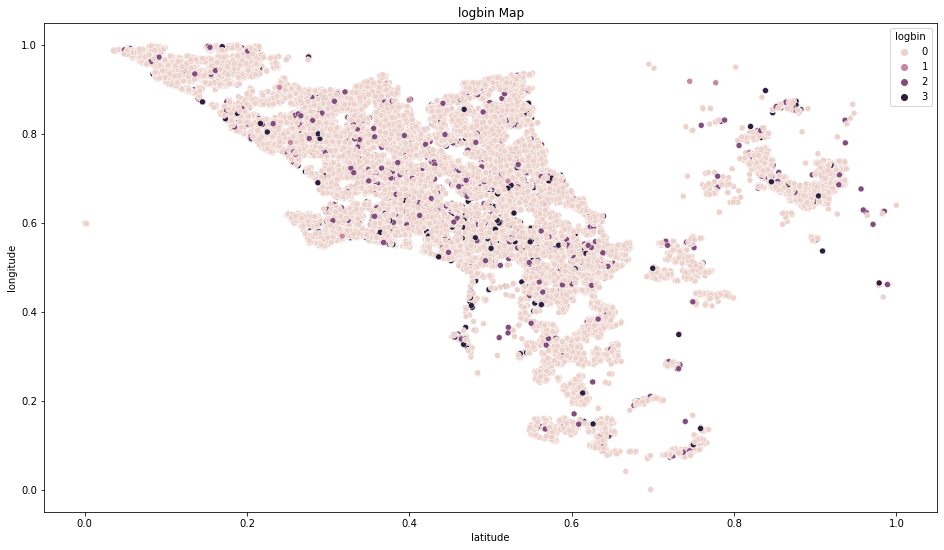

In [18]:
train_scaled['logbin'] = X['logbin']
cluster.map_clusters(train_scaled, 'logbin')

### Price

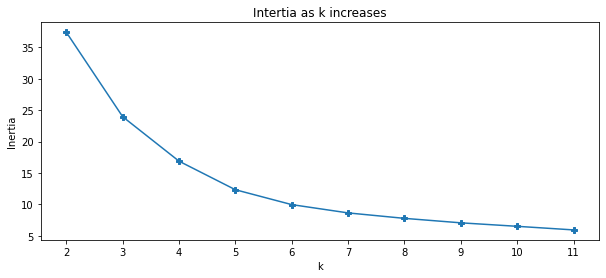

In [19]:
X = train_scaled[['taxvaluedollarcnt','structuretaxvaluedollarcnt','taxamount']]
cluster.view_intertia(X)

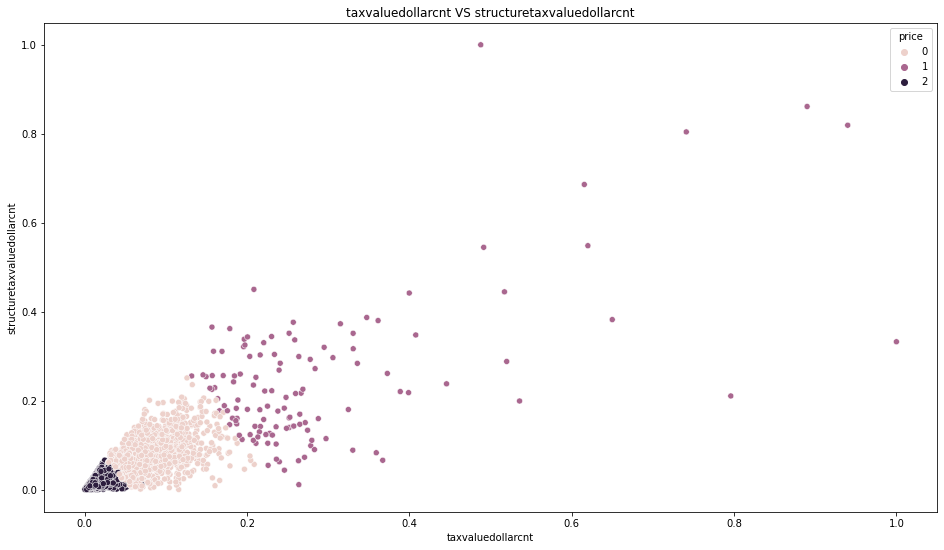

In [20]:
X = cluster.show_cluster(X, 3, 'price')

In [21]:
#Add clusters onto existing training dataset
train_scaled['price'] = X['price']

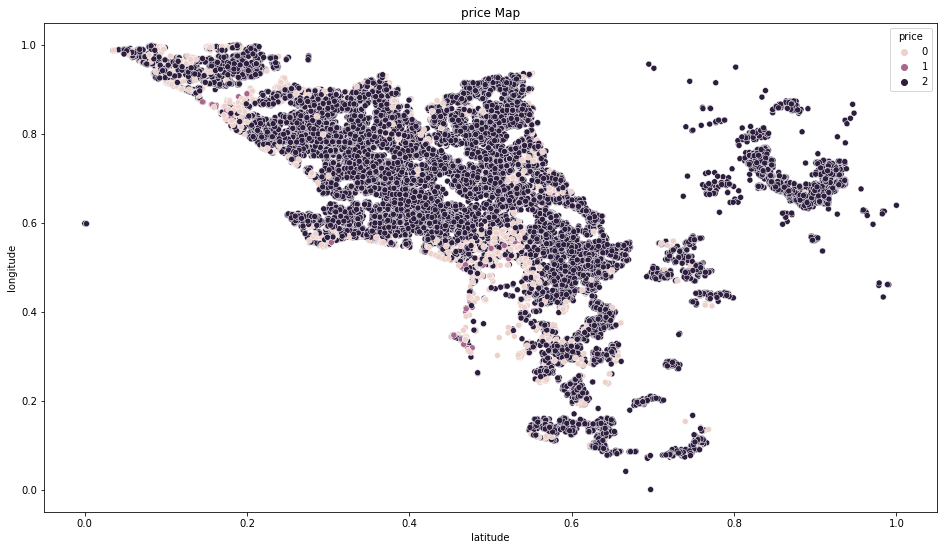

In [22]:
cluster.map_clusters(train_scaled, 'price')

### Size

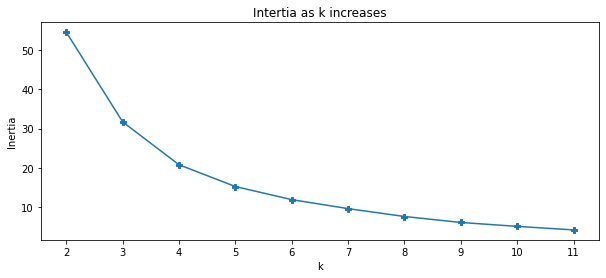

In [23]:
X = train_scaled[['calculatedfinishedsquarefeet','finishedsquarefeet12','lotsizesquarefeet']]
cluster.view_intertia(X)

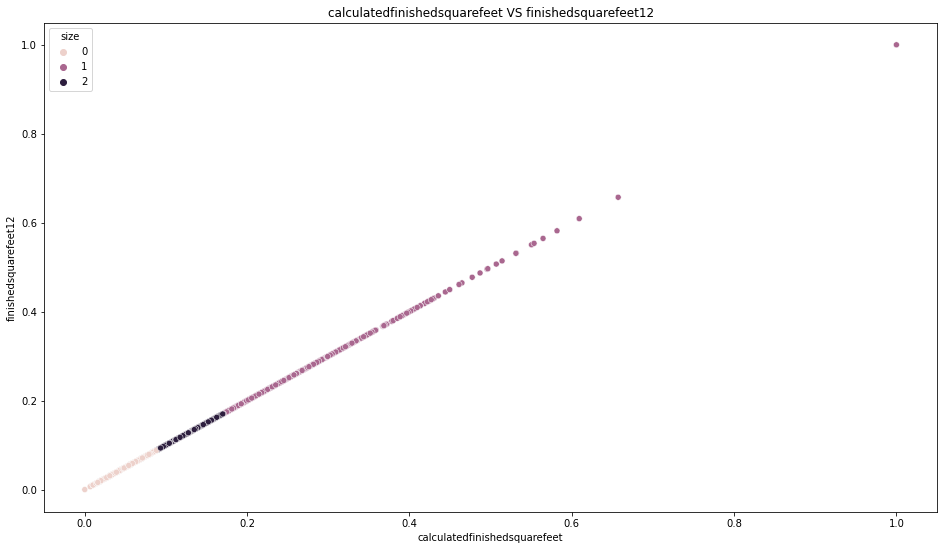

In [24]:
X = cluster.show_cluster(X, 3, 'size')

In [25]:
train_scaled['size'] = X['size']

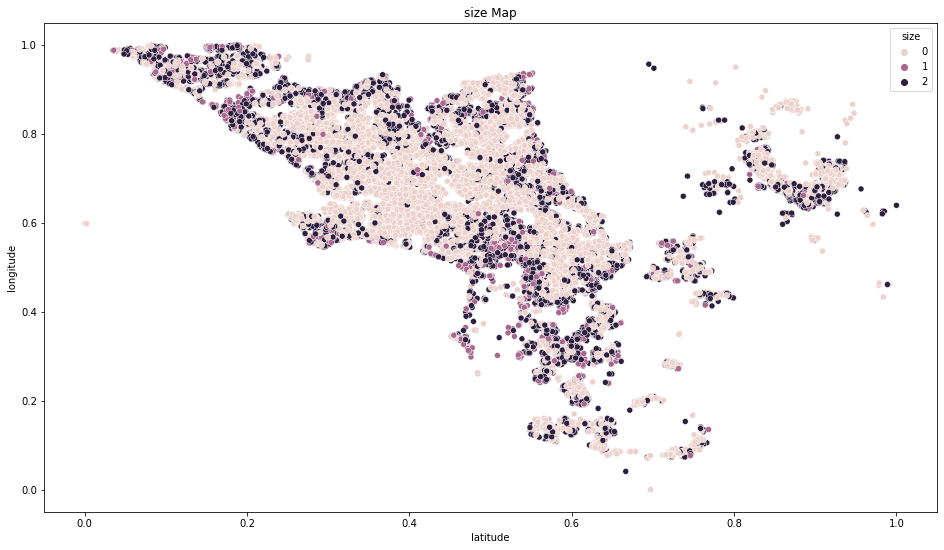

In [26]:
cluster.map_clusters(train_scaled, 'size')

### Age

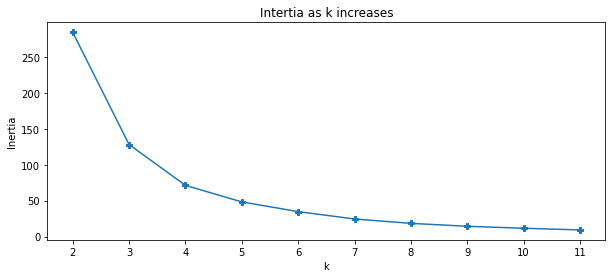

In [27]:
X = train_scaled[['yearbuilt']]
cluster.view_intertia(X)

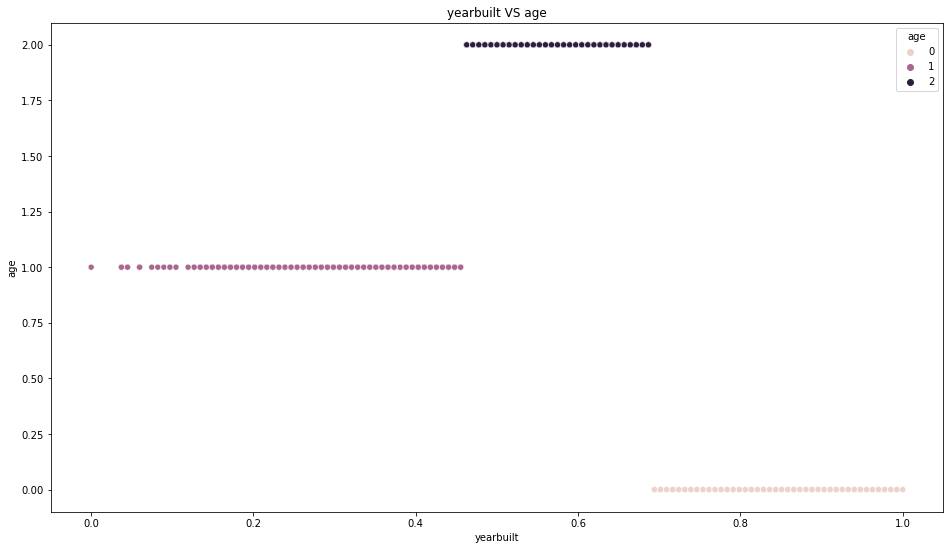

In [28]:
X = cluster.show_cluster(X, 3, 'age')

In [29]:
train_scaled['age'] = X['age']

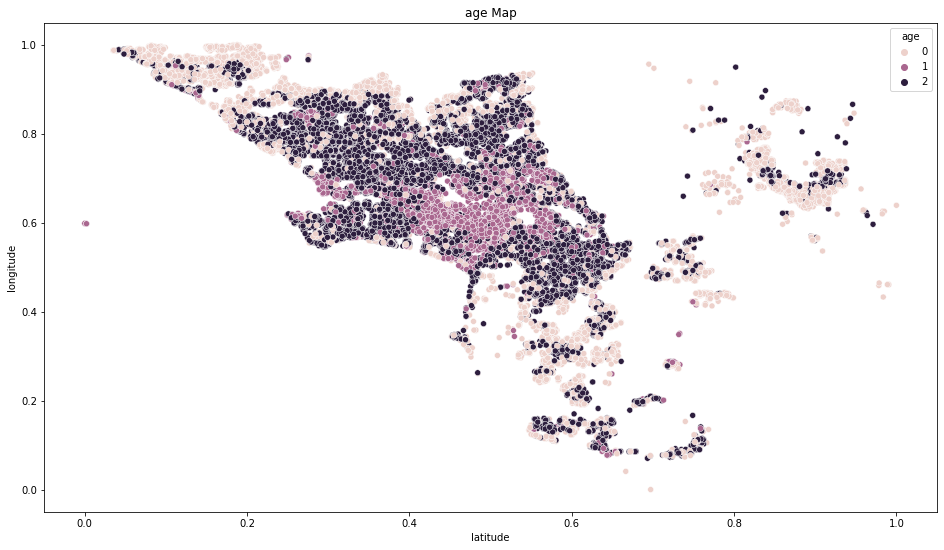

In [30]:
cluster.map_clusters(train_scaled, 'age')

## Cross Referencing our Big 3

### Size vs Price

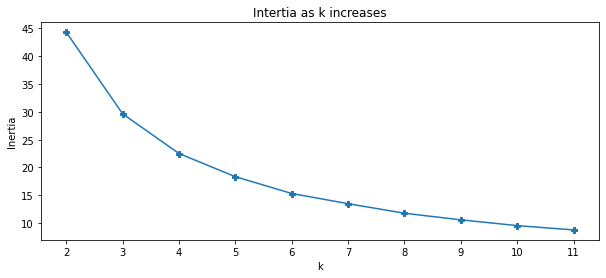

In [31]:
X = train_scaled[['calculatedfinishedsquarefeet', 'taxvaluedollarcnt']]
cluster.view_intertia(X)

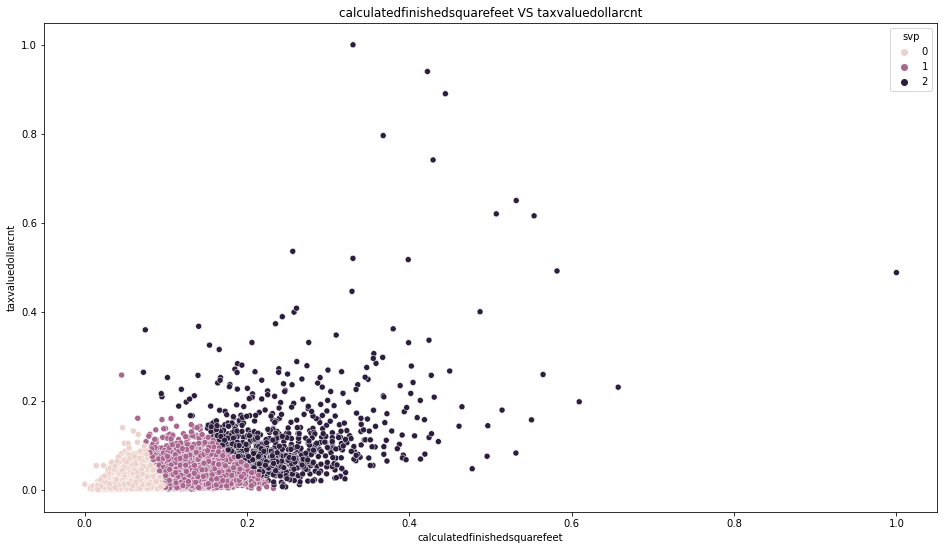

In [32]:
#Price vs Size
X = cluster.show_cluster(X, 3, 'svp')

In [33]:
train_scaled['svp'] = X['svp']

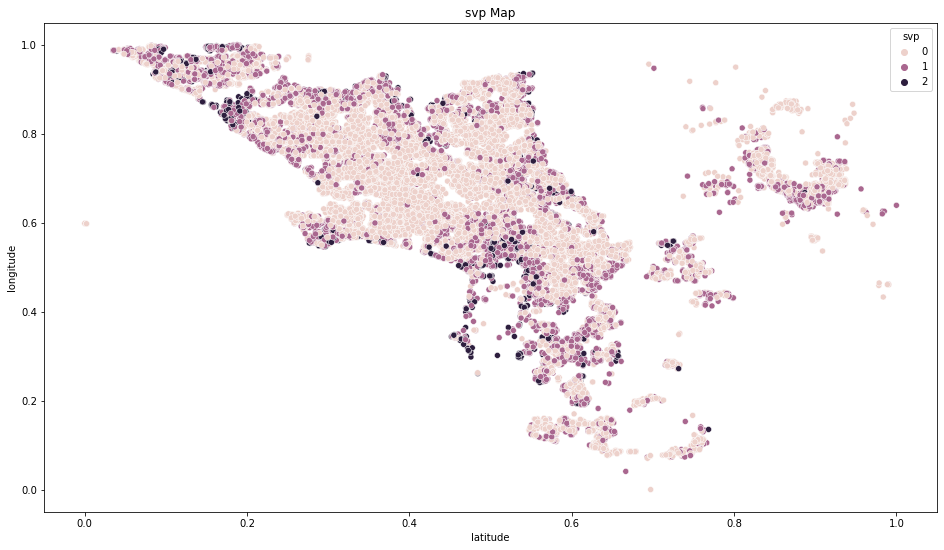

In [34]:
cluster.map_clusters(train_scaled, 'svp')

### Price vs Age

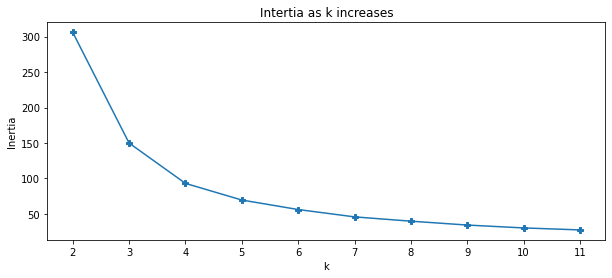

In [35]:
X = train_scaled[['taxvaluedollarcnt', 'yearbuilt']]
cluster.view_intertia(X)

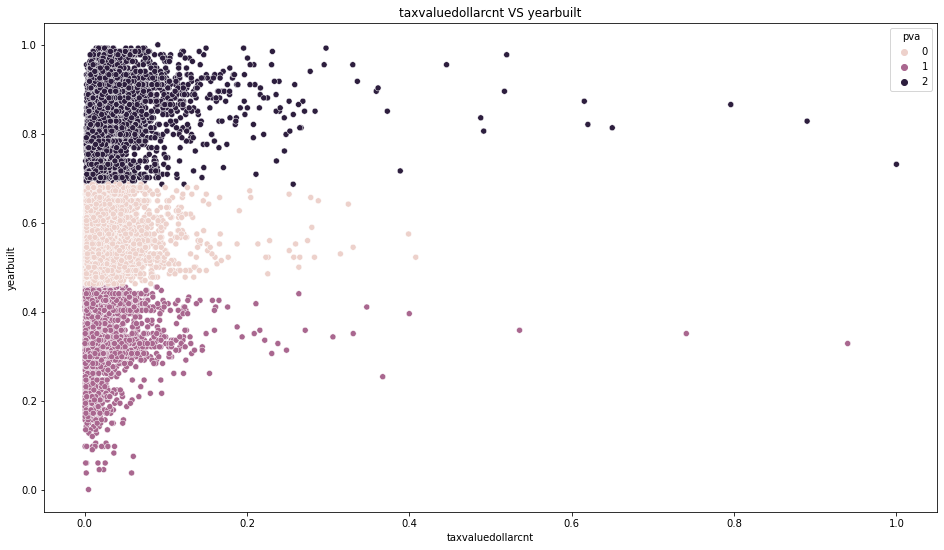

In [36]:
#price VS age
X = cluster.show_cluster(X, 3, 'pva')

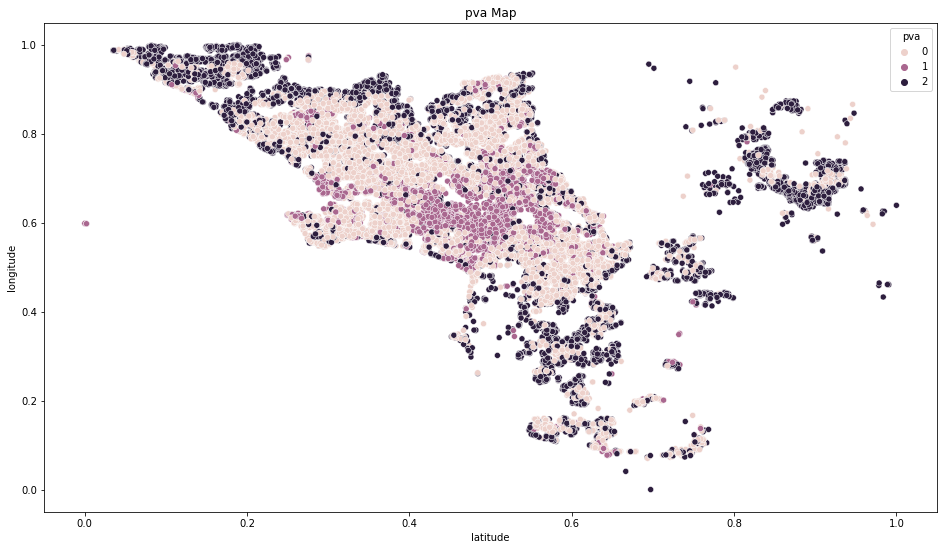

In [37]:
train_scaled['pva'] = X['pva']
cluster.map_clusters(train_scaled, 'pva')

### Age vs Size

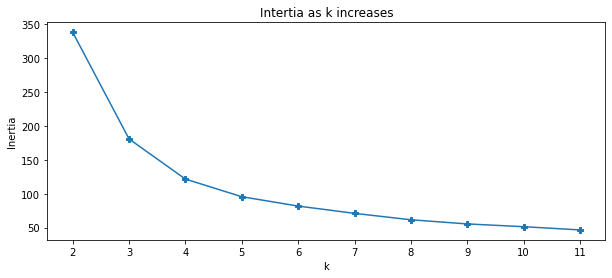

In [38]:
X = train_scaled[[ 'yearbuilt', 'calculatedfinishedsquarefeet']]
cluster.view_intertia(X)

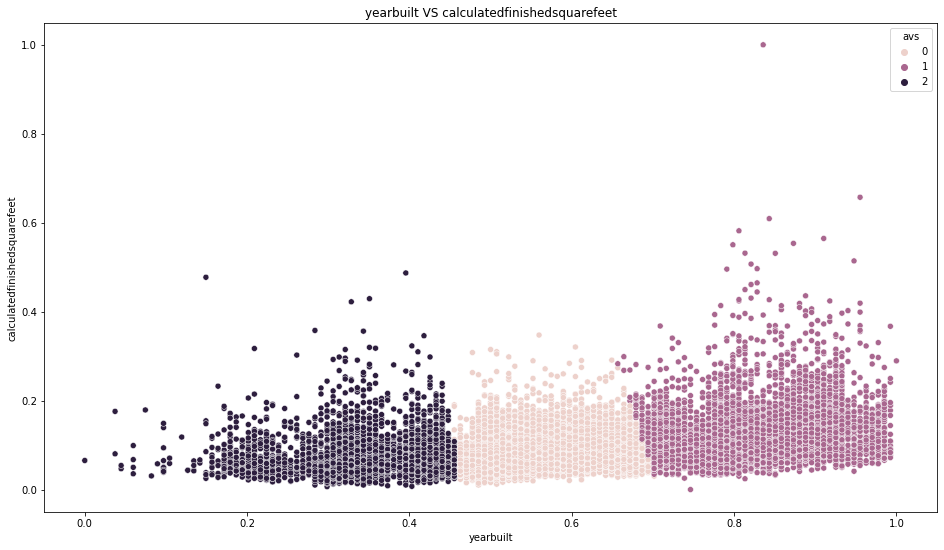

In [39]:
X = cluster.show_cluster(X, 3, 'avs')

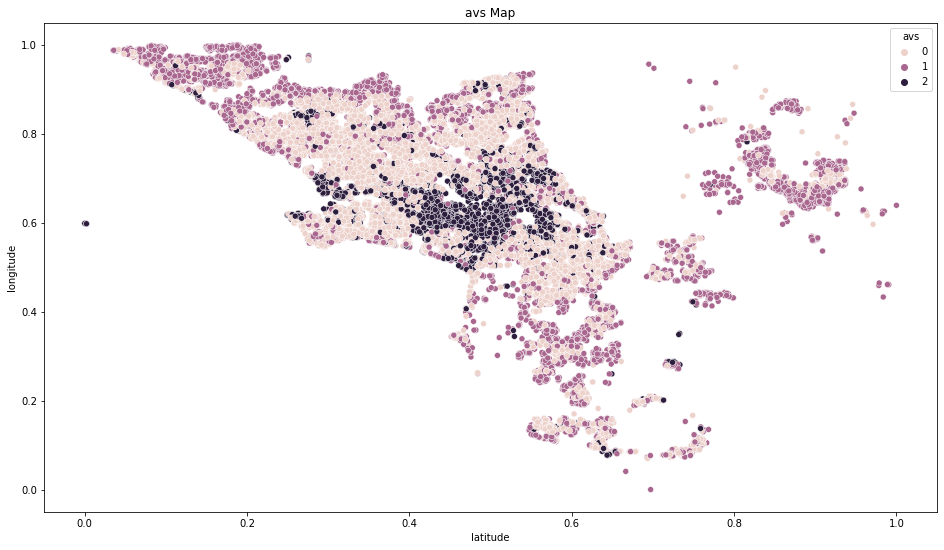

In [40]:
train_scaled['avs'] = X['avs']
cluster.map_clusters(train_scaled, 'avs')

## All 3

### Size vs Price vs Age

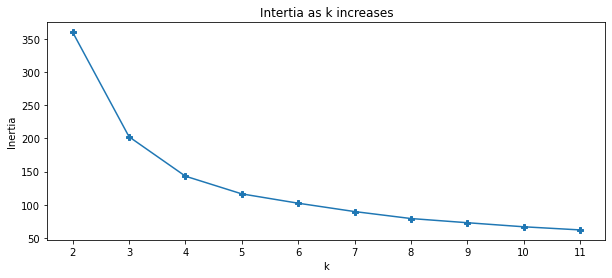

In [41]:
X = train_scaled[['calculatedfinishedsquarefeet', 'taxvaluedollarcnt', 'yearbuilt']]
cluster.view_intertia(X)

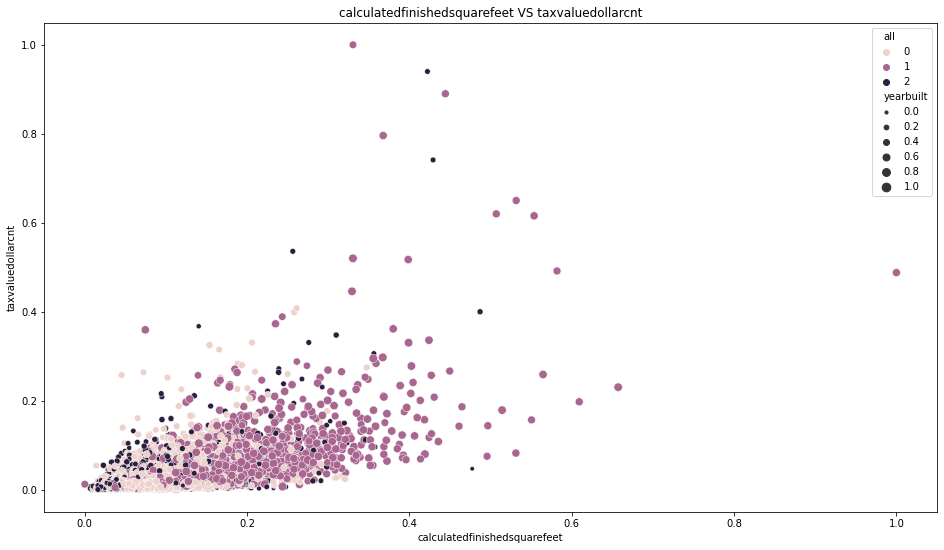

In [42]:
X = cluster.show_cluster(X, 3, 'all', 'yearbuilt')

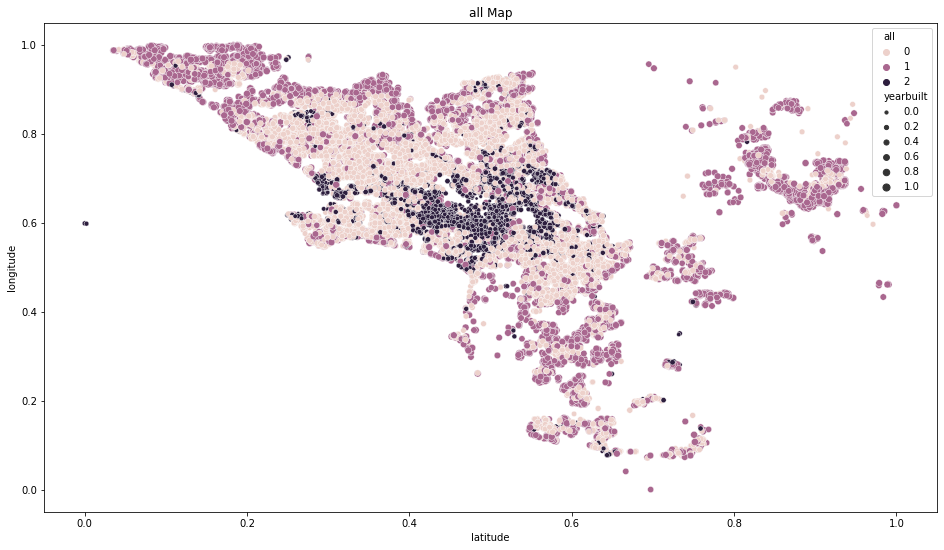

In [43]:
train_scaled['all'] = X['all']
cluster.map_clusters(train_scaled, 'all', 'yearbuilt' )

### Find Trend

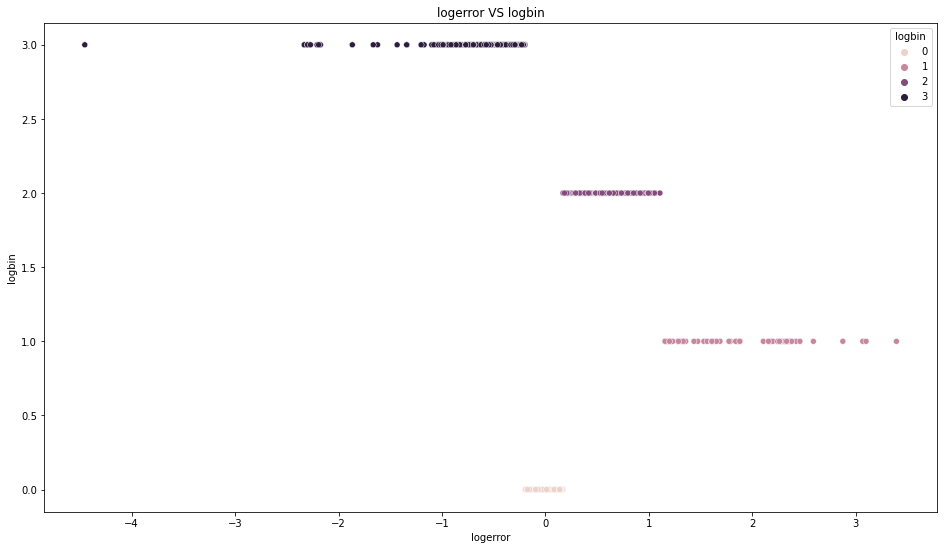

In [44]:
X = train_scaled[['logerror']]
X = cluster.show_cluster(X, 4, 'logbin',hide= False)
train_scaled['logbin'] = X['logbin']

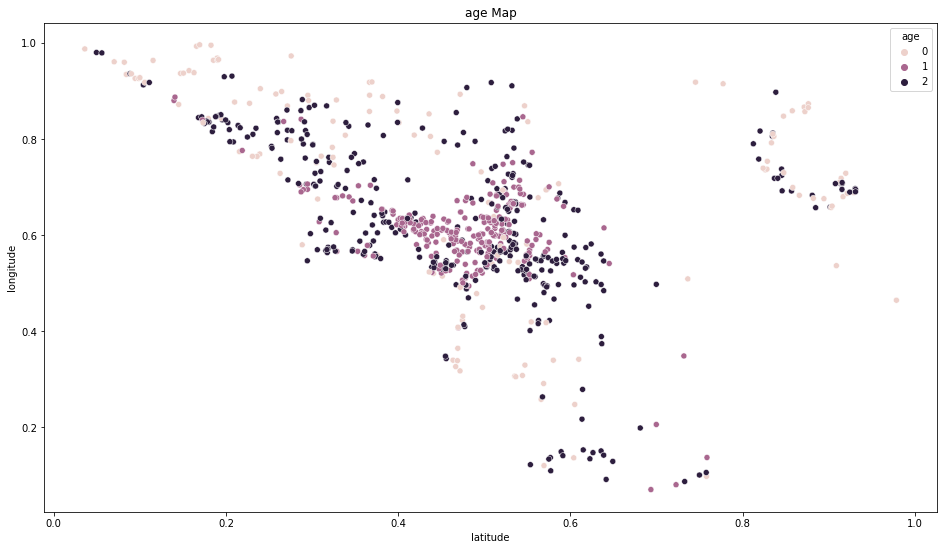

In [45]:
cluster.map_clusters(train_scaled[(train_scaled['logbin']== 3) | (train_scaled['logbin']== 1)], 'age')

## Major Takeaway 
- Majority of the houses that had the most log error are either cheaper or smaller

- There are more cheaper and smaller houses in the dataset, do they need there own model to be accurate?

### Next steps
1. Do different price markets have different drivers for predicting log error
2. Do the cluster columns created help or hinder predicting log error? 
3. Do different markets need to have an entirely different models in order to be accurate in predictiong log error.

In [46]:
#add clusters to validate and test dataframes

In [47]:
#---Validate---
X = validate_scaled[['taxvaluedollarcnt']]
X = cluster.show_cluster(X, 3, 'price',hide= True)
validate_scaled['price'] = X['price']

X = validate_scaled[['calculatedfinishedsquarefeet']]
X = cluster.show_cluster(X, 3, 'size',hide= True)
validate_scaled['size'] = X['size']

X = validate_scaled[['yearbuilt']]
X = cluster.show_cluster(X, 3, 'age',hide= True)
validate_scaled['age'] = X['age']

X = validate_scaled[['calculatedfinishedsquarefeet', 'taxvaluedollarcnt']]
X = cluster.show_cluster(X, 3, 'svp',hide= True)
validate_scaled['svp'] = X['svp']

X = validate_scaled[['taxvaluedollarcnt', 'yearbuilt']]
X = cluster.show_cluster(X, 3, 'pva',hide= True)
validate_scaled['pva'] = X['pva']

X = validate_scaled[[ 'yearbuilt', 'calculatedfinishedsquarefeet']]
X = cluster.show_cluster(X, 3, 'avs',hide= True)
validate_scaled['avs'] = X['avs']

X = validate_scaled[['calculatedfinishedsquarefeet', 'taxvaluedollarcnt', 'yearbuilt']]
X = cluster.show_cluster(X, 3, 'all',size = 'yearbuilt',hide= True)
validate_scaled['all'] = X['all']

#---Test---
X = test_scaled[['taxvaluedollarcnt']]
X = cluster.show_cluster(X, 3, 'price',hide= True)
test_scaled['price'] = X['price']

X = test_scaled[['calculatedfinishedsquarefeet']]
X = cluster.show_cluster(X, 3, 'size',hide= True)
test_scaled['size'] = X['size']

X = test_scaled[['yearbuilt']]
X = cluster.show_cluster(X, 3, 'age',hide= True)
test_scaled['age'] = X['age']

X = test_scaled[['calculatedfinishedsquarefeet', 'taxvaluedollarcnt']]
X = cluster.show_cluster(X, 3, 'svp',hide= True)
test_scaled['svp'] = X['svp']

X = test_scaled[['taxvaluedollarcnt', 'yearbuilt']]
X = cluster.show_cluster(X, 3, 'pva',hide= True)
test_scaled['pva'] = X['pva']

X = test_scaled[[ 'yearbuilt', 'calculatedfinishedsquarefeet']]
X = cluster.show_cluster(X, 3, 'avs',hide= True)
test_scaled['avs'] = X['avs']

X = test_scaled[['calculatedfinishedsquarefeet', 'taxvaluedollarcnt', 'yearbuilt']]
X = cluster.show_cluster(X, 3, 'all',size = 'yearbuilt',hide= True)
test_scaled['all'] = X['all']

In [48]:
#drop non-numerical columns and id columns for modeling, drop logbin for modeling

In [49]:
train_scaled = train_scaled.drop(columns=['propertylandusetypeid','parcelid','id','id.1',\
                                          'transactiondate','propertycountylandusecode',\
                                          'propertylandusedesc','logbin'])
validate_scaled = validate_scaled.drop(columns=['propertylandusetypeid','parcelid','id','id.1',\
                                          'transactiondate','propertycountylandusecode',\
                                          'propertylandusedesc'])
test_scaled = test_scaled.drop(columns=['propertylandusetypeid','parcelid','id','id.1',\
                                          'transactiondate','propertycountylandusecode',\
                                          'propertylandusedesc'])

### 1. Does each housing market prioritize different drivers?

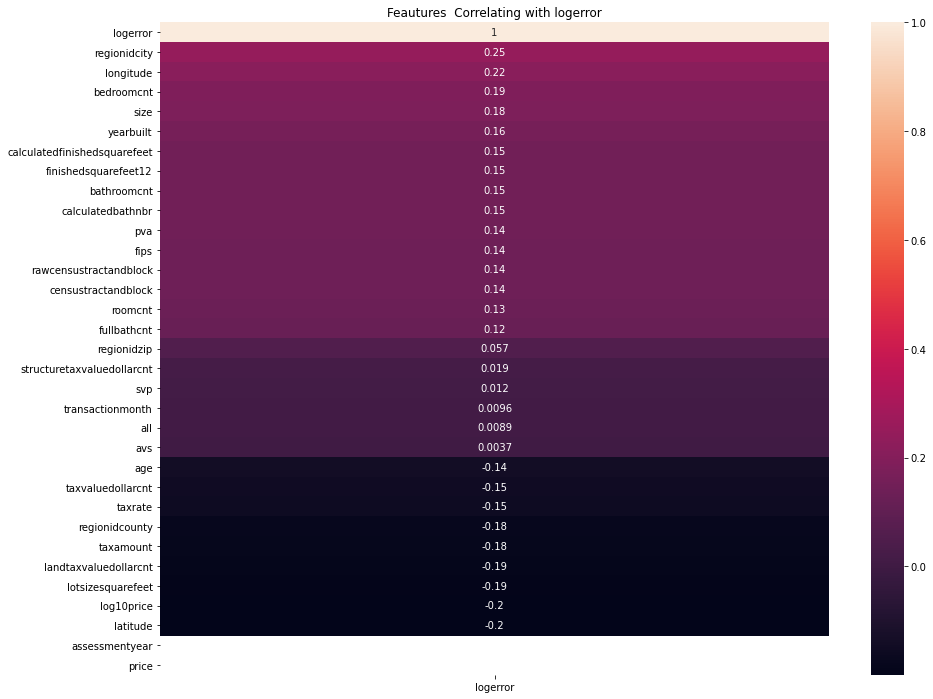

<AxesSubplot:title={'center':'Feautures  Correlating with logerror'}>

In [57]:
#explore.get_heatmap(train_scaled, 'logerror')
explore.get_heatmap(train_scaled[train_scaled['price'] == 1], 'logerror')

#### Drivers

In [51]:
X_train = train_scaled.drop(columns=['logerror'])
y_train = train_scaled[['logerror','price']]

X_validate = validate_scaled.drop(columns=['logerror'])
y_validate = validate_scaled[['logerror','price']]

X_test = test_scaled.drop(columns=['logerror'])
y_test = test_scaled[['logerror','price']]

y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)

#### K-Best and RFE

In [64]:
kbest = evaluate.select_kbest(X_train, y_train,8 )
kbest0 = evaluate.select_kbest(evaluate.get_price(X_train,0),evaluate.get_price(y_train,0), 3)
kbest1 = evaluate.select_kbest(evaluate.get_price(X_train,1),evaluate.get_price(y_train,1), 3)
kbest2 = evaluate.select_kbest(evaluate.get_price(X_train,2),evaluate.get_price(y_train,2), 3)


In [65]:
rfe = evaluate.select_rfe(X_train, y_train,8)
rfe0 = evaluate.select_rfe(evaluate.get_price(X_train,0),evaluate.get_price(y_train,0), 1)
rfe1 = evaluate.select_rfe(evaluate.get_price(X_train,1),evaluate.get_price(y_train,1), 3)
rfe2 = evaluate.select_rfe(evaluate.get_price(X_train,2),evaluate.get_price(y_train,2), 3)

### Takeaways
 - Each housing market has different drivers for predicting log error.
 - We will use these specifc drivers for each model when running our predicitons for answering step number 3
 - each market differs in the amount of drivers needed to be accurate, high logerror markets need more drivers, lower markets dont need as many drivers


### 2. Do the cluster columns created help or hinder predicting log error? 
- Here we will run a linear regression model using the top 5 rfe and the top 5 rfe + the ones created created by clustering  to see if it improves our rmse score.

In [66]:
target = 'logerror'
rfe_clusters = rfe + ['price', 'size', 'age', 'svp', 'pva', 'avs', 'all']

#### RFE

In [124]:
baseline = evaluate.baseline_errors(y_train.logerror)[2]

In [123]:
Rfe_train_results = evaluate.get_model_results(X_train[rfe], y_train.logerror, X_validate[rfe], y_validate ,target,'linear')
print('Baseline:   {}'.format(baseline))
print('Better than baseline: {}'.format(Rfe_train_results[1] < baseline))

r2 Score:  0.0041657073823025866
RMSE Score: 0.18204563080514338
Baseline:   0.17089678978658412
Better than baseline: False


In [69]:
rfe_validate_results = evaluate.get_model_results(X_train[rfe], y_train.logerror, X_validate[rfe], y_validate ,target,'linear')
print('Baseline:   {}'.format(baseline))
print('Better than baseline: {}'.format(Rfe_train_results[1] < baseline))

r2 Score:  0.004192984142310057
RMSE Score: 0.1820583842801868
Baseline:   0.17089678978658412
Better than baseline: False


#### RFE + Cluster columns

In [70]:
cluster_results_train = evaluate.get_model_results(X_train[rfe_clusters], y_train.logerror, X_train[rfe_clusters], y_train, target, 'linear')
print('Baseline:   {}'.format(baseline))
print('Better than baseline: {}'.format(cluster_results_train[1] < baseline))

r2 Score:  0.0059814373419182065
RMSE Score: 0.17038491898775474
Baseline:   0.17089678978658412
Better than baseline: True


In [71]:
cluster_results_validate = evaluate.get_model_results(X_train[rfe_clusters], y_train.logerror, X_validate[rfe_clusters], y_validate , target, 'linear')
print('Baseline:   {}'.format(baseline))
print('Better than baseline: {}'.format(cluster_results_validate[1] < baseline))

r2 Score:  0.030498500248930433
RMSE Score: 0.18432664370398577
Baseline:   0.17089678978658412
Better than baseline: False


### Takeaways
- Our Created cluster columns were able to help the model on the test phase, but not when validating
- This plays a big role into what was found earlier in step one. Not every housing market priortizes the same driver. so in order us to be accurate in our results, we must break our models up into housing markets to see what regression model best fits the data
- In step 3, We will change the drivers based on which housing market we are looking at in the moment. 

## 3. Do different markets need to have an entirely different models in order to be accurate in predicting log error.

### Here we look at the best model when we dont split up the data based on market

In [72]:
baseline = evaluate.baseline_errors(y_train.logerror)[2]

In [73]:
one_model_train_results = evaluate.get_model_results(X_train[rfe], y_train.logerror, X_train[rfe], y_train ,target,'poly')
print('Baseline:   {}'.format(baseline))
print('Better than baseline: {}'.format(one_model_train_results[1] < baseline))

r2 Score:  0.008754775284596467
RMSE Score: 0.17014227084249783
Baseline:   0.17089678978658412
Better than baseline: True


In [74]:
one_model_validate_results = evaluate.get_model_results(X_train[kbest], y_train.logerror, X_validate[kbest], y_validate ,target,'poly')
print('Baseline:   {}'.format(baseline))
print('Better than baseline: {}'.format(one_model_validate_results[1] < baseline))

r2 Score:  0.024874680739466363
RMSE Score: 0.18373464176881066
Baseline:   0.17089678978658412
Better than baseline: False


## Takeaways
- The best model to use if we only use one model for all the data is a 2 degree polynomial, it was able to beat the train but no model or combination of drivers was able to beat the validate stage.
- Now we will find the best model for housing market, consolidate the results and see if this approach is better than having one model to determine logerror 

### Best Model for Market 2 (cheapest Market)

In [155]:
baseline = evaluate.baseline_errors(evaluate.get_price(y_train,2).logerror)[2]

In [156]:
market2Results_train = evaluate.get_model_results(evaluate.get_price(X_train, 0)[rfe2], evaluate.get_price(y_train, 0).logerror,\
                                            evaluate.get_price(X_train, 0)[rfe2], evaluate.get_price(y_train, 0), target , 'linear')
print('Baseline:   {}'.format(baseline))
print('Better than baseline: {}'.format(market0Results_train[1] < baseline))

r2 Score:  0.024077675050936116
RMSE Score: 0.18476366133101818
Baseline:   0.1679677773715255
Better than baseline: False


In [157]:
market2Results_validate = evaluate.get_model_results(evaluate.get_price(X_train, 0)[rfe2], evaluate.get_price(y_train, 0).logerror,\
                                            evaluate.get_price(X_validate, 0)[rfe2], evaluate.get_price(y_validate, 0), target, 'linear')
print('Baseline:   {}'.format(baseline))
print('Better than baseline: {}'.format(market0Results_validate[1] < baseline))

r2 Score:  0.024826752001493903
RMSE Score: 0.17429221444914586
Baseline:   0.1679677773715255
Better than baseline: False


### Best Model for Market 0 (middle Market)

In [158]:
market2Results_train = evaluate.get_model_results(evaluate.get_price(X_train, 0)[rfe0], evaluate.get_price(y_train, 0).logerror,\
                                            evaluate.get_price(X_train, 0)[rfe0], evaluate.get_price(y_train, 0), target , 'poly')
print('Baseline:   {}'.format(baseline))
print('Better than baseline: {}'.format(market2Results_train[1] < baseline))

r2 Score:  0.053323545427575864
RMSE Score: 0.1820017288187519
Baseline:   0.1679677773715255
Better than baseline: False


In [152]:
rfe0 = evaluate.select_rfe(evaluate.get_price(X_train,0),evaluate.get_price(y_train,0), 12)
rfe1 = evaluate.select_rfe(evaluate.get_price(X_train,1),evaluate.get_price(y_train,1), 8)
rfe2 = evaluate.select_rfe(evaluate.get_price(X_train,2),evaluate.get_price(y_train,2), 5)